<a href="https://colab.research.google.com/github/poojitharajapuram/HW6_ML/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
url = 'https://raw.githubusercontent.com/poojitharajapuram/HW6_ML/main/Housing.csv'
df = pd.read_csv(url)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [12]:
df['furnishingstatus'].value_counts().unique
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [13]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=False)
df = df.drop('furnishingstatus_semi-furnished', axis=1)
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,1,0
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,1,0
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,0,0
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,1,0
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,1,0


In [14]:
binary_columns = df.select_dtypes(include=['object']).columns
binary_columns

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')

In [15]:
df[binary_columns] = df[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,0


In [16]:
df.shape

(545, 14)

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [19]:
X = df.drop('price', axis = 1)
y = df[['price']]

In [20]:
X = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns, index=X.index).values
y = pd.DataFrame(scaler_y.fit_transform(y), columns=y.columns, index=y.index).values

In [21]:
train_X, val_X, train_Y, val_Y = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(train_X)
y_train =  torch.tensor(train_Y)
X_val =  torch.tensor(val_X)
y_val =  torch.tensor(val_Y)

In [22]:
training_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [23]:
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=32)

In [24]:
def model_train(model, criterion, optimizer, epochs, train_loader, X_val, y_val):
    loss_train = []
    loss_val = []
    for epoch in range(epochs + 1):
        # Training
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            if epoch % 500 == 0:
              print(f'Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')
              loss_val.append(val_loss)
              loss_train.append(loss)
    return loss_train, loss_val

1a


In [26]:
# Model 1
model1 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 1)
).to(torch.float64)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
train_loss, val_loss = model_train(model1, nn.MSELoss(), optimizer1, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.02698102848946455, Validation Loss: 0.08106348091805361
Epoch 500/5000, Training Loss: 0.0041954115987384785, Validation Loss: 0.01341049758837029
Epoch 1000/5000, Training Loss: 0.010227274484256626, Validation Loss: 0.013347764387706238
Epoch 1500/5000, Training Loss: 0.005463253751942698, Validation Loss: 0.013392803993029124
Epoch 2000/5000, Training Loss: 0.009964170177248845, Validation Loss: 0.013395996224367891
Epoch 2500/5000, Training Loss: 0.008213883591921272, Validation Loss: 0.013495716649759631
Epoch 3000/5000, Training Loss: 0.0023551369999881408, Validation Loss: 0.013556457670174476
Epoch 3500/5000, Training Loss: 0.00864362205852098, Validation Loss: 0.013531155346930059
Epoch 4000/5000, Training Loss: 0.007255854282950848, Validation Loss: 0.013618948236739864
Epoch 4500/5000, Training Loss: 0.004540979309159308, Validation Loss: 0.013742091184800949
Epoch 5000/5000, Training Loss: 0.005277127895350726, Validation Loss: 0.0137318626737

In [27]:
for name, param in model1.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")


Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([1, 32])
Parameter name: 2.bias, Shape: torch.Size([1])


In [28]:
total_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  481 



In [29]:
epochs = range(0, 5001, 500)
epochs


range(0, 5001, 500)

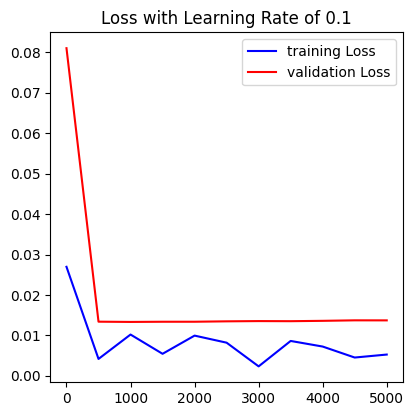

In [30]:
plt.figure(figsize=(10, 10))
plt.title('Loss for optimizer - SGD')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss]), color='blue', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss]), color='red', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.1')
plt.legend()

plt.show()

1b


In [31]:
model2 = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.Tanh(),
    nn.Linear(32, 64),  # Second hidden layer with 64 neurons
    nn.Tanh(),
    nn.Linear(64, 16),  # Third hidden layer with 16 neurons
    nn.Tanh(),
    nn.Linear(16, 1) # Output layer with 1 neuron
).to(torch.float64)
criterion = nn.MSELoss()
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
train_loss_2, val_loss_ = model_train(model2, nn.MSELoss(), optimizer2, 5000, train_loader, X_val, y_val)


Epoch 0/5000, Training Loss: 0.07037433867431322, Validation Loss: 0.09063321416499248
Epoch 500/5000, Training Loss: 0.0023201141811803085, Validation Loss: 0.013661052116714695
Epoch 1000/5000, Training Loss: 0.014691971315300348, Validation Loss: 0.013512469556427724
Epoch 1500/5000, Training Loss: 0.008217535710070344, Validation Loss: 0.013374648000856868
Epoch 2000/5000, Training Loss: 0.005837440186875348, Validation Loss: 0.013346765300367255
Epoch 2500/5000, Training Loss: 0.008425877531545656, Validation Loss: 0.013355495858725194
Epoch 3000/5000, Training Loss: 0.012971492620371741, Validation Loss: 0.013161869117131731
Epoch 3500/5000, Training Loss: 0.016901629170911613, Validation Loss: 0.013099333237521589
Epoch 4000/5000, Training Loss: 0.011004004606810211, Validation Loss: 0.013089586120316266
Epoch 4500/5000, Training Loss: 0.005284486785680623, Validation Loss: 0.013063640885396799
Epoch 5000/5000, Training Loss: 0.003438100493333398, Validation Loss: 0.013083703329

In [32]:
for name, param in model2.named_parameters():
    print(f"Parameter name: {name}, Shape: {param.shape}")

Parameter name: 0.weight, Shape: torch.Size([32, 13])
Parameter name: 0.bias, Shape: torch.Size([32])
Parameter name: 2.weight, Shape: torch.Size([64, 32])
Parameter name: 2.bias, Shape: torch.Size([64])
Parameter name: 4.weight, Shape: torch.Size([16, 64])
Parameter name: 4.bias, Shape: torch.Size([16])
Parameter name: 6.weight, Shape: torch.Size([1, 16])
Parameter name: 6.bias, Shape: torch.Size([1])


In [35]:
total_params = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Total number of trainable parameters ", total_params,  '\n')

Total number of trainable parameters  3617 



NameError: ignored

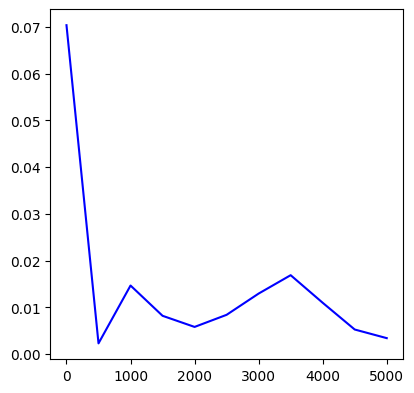

In [38]:
plt.figure(figsize=(10, 10))
plt.title('Loss for optimizer - SGD')

plt.subplot(2,2,1)
plt.plot(epochs, np.array([item.detach().item() for item in train_loss_2]), color='blue', label = 'training Loss')
plt.plot(epochs, np.array([item.detach().item() for item in val_loss_2]), color='red', label = 'validation Loss')
plt.title('Loss with Learning Rate of 0.1')
plt.legend()

plt.show()


In [39]:
!pip install ipython-autotime
%load_ext autotime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00
time: 418 µs (started: 2023-12-01 22:03:28 +00:00)


In [40]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


time: 637 ms (started: 2023-12-01 22:04:05 +00:00)


In [41]:
torch.manual_seed(123)

time: 14.1 ms (started: 2023-12-01 22:04:26 +00:00)


In [42]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)


100%|██████████| 170498071/170498071 [00:06<00:00, 25499372.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
time: 29.5 s (started: 2023-12-01 22:05:00 +00:00)


In [43]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 67.5 ms (started: 2023-12-01 22:06:39 +00:00)


In [44]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 10.9 ms (started: 2023-12-01 22:06:57 +00:00)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time: 971 µs (started: 2023-12-01 22:07:38 +00:00)


In [46]:
device

device(type='cpu')

time: 4.53 ms (started: 2023-12-01 22:07:59 +00:00)


In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
])

time: 1.11 ms (started: 2023-12-01 22:08:24 +00:00)


In [48]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 1.69 s (started: 2023-12-01 22:09:19 +00:00)


In [49]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 516 ms (started: 2023-12-01 22:09:51 +00:00)


In [50]:
first_image, label = cifar10[0]
print(first_image.shape)

torch.Size([3, 32, 32])
time: 14.9 ms (started: 2023-12-01 22:10:51 +00:00)


In [51]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)


time: 3.41 ms (started: 2023-12-01 22:11:35 +00:00)


In [52]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 10)
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

time: 50.8 ms (started: 2023-12-01 22:11:52 +00:00)


In [55]:
def train_model(model, train_loader, test_loader, num_epochs=300, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Testing the model
        model.eval()
        correct = 0
        total = 0
        all_predicted = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predicted.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total

        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Test Accuracy: {accuracy * 100:.2f}%')

    # Classification Report
    report = classification_report(all_labels, all_predicted)
    print("Classification Report:\n", report)


time: 2.26 ms (started: 2023-12-01 22:14:59 +00:00)


In [56]:
train_model(model, train_loader, test_loader, num_epochs=300, lr=0.01)

Epoch 1/300, Loss: 1.7886348081870638, Test Accuracy: 40.94%
Epoch 2/300, Loss: 1.6521172705020037, Test Accuracy: 43.15%
Epoch 3/300, Loss: 1.5804378465437692, Test Accuracy: 44.45%
Epoch 4/300, Loss: 1.5198366514246813, Test Accuracy: 45.26%
Epoch 5/300, Loss: 1.4625313013544161, Test Accuracy: 46.44%
Epoch 6/300, Loss: 1.4085316710646, Test Accuracy: 47.50%
Epoch 7/300, Loss: 1.3539841107580803, Test Accuracy: 47.11%
Epoch 8/300, Loss: 1.3031534532744078, Test Accuracy: 47.23%
Epoch 9/300, Loss: 1.249340126015632, Test Accuracy: 48.36%
Epoch 10/300, Loss: 1.1990976107097633, Test Accuracy: 47.90%
Epoch 11/300, Loss: 1.147438968516891, Test Accuracy: 48.39%
Epoch 12/300, Loss: 1.0958708692496966, Test Accuracy: 49.10%
Epoch 13/300, Loss: 1.0460041413990564, Test Accuracy: 48.73%
Epoch 14/300, Loss: 0.9943198018247931, Test Accuracy: 48.12%
Epoch 15/300, Loss: 0.9466876947223873, Test Accuracy: 48.06%
Epoch 16/300, Loss: 0.8974496146195681, Test Accuracy: 48.03%
Epoch 17/300, Loss: 0.

In [57]:
model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32 * 32 * 3, 512),
    nn.Tanh(),
    nn.Linear(512, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.Tanh(),
    nn.Linear(128, 10)
).to(device)


time: 42.7 ms (started: 2023-12-02 01:27:57 +00:00)


In [ ]:
train_model(model2, train_loader, test_loader, num_epochs=300, lr=0.01)
